# Introduction

This is a python notebook where I will be coding a neural network engine from scratch by following this amazing video from Mr Andrej Karpathy (<a href="https://www.youtube.com/watch?v=VMj-3S1tku0">Click Here</a>). 

## What is micrograd ?
It is the implementation of the backpropagation step in neural networks. Backprop works by evaluating a gradient with a loss function (example: CrossEntropyLoss, MSE, MAE) with respect to the weights of the neural network. 
Calling <code>g.backward()</code> will:
1. start backprop from node 'g'
2. apply chain rule recursively (reminder: dy/dx = dy/du * du/dx. du/dx -> how 'u' will grow upon changing 'x').

In short, we find the derivating of node 'g' with respect to all nodes+inputs


In [7]:
## Library Imports

import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
# creating the Value object and enabling functions such as addition and subtraction


class Value:
    def __init__(self, data, _children=(), _op="", label="") -> None:
        """
        data: value of the neuron (activation value)
        _children: set. used to store the children of the node
        label: neuron reference name
        """
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        # keeping track of derivative of the node
        self.grad = 0
        # store chain rule. by default does nothing
        self._backward = lambda: None

    def __repr__(self) -> str:
        """
        print the value stored within the Value object
        """
        return f"Value(data={self.data})"

    def __add__(self, other) -> int | float:
        # if we are trying to add integer to a Value object, convert the number into a Value object then extract its value and add
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            # here we accumulate gradient as it is possible we may have multivariable contribution backwards. depositing gradients from mutliple branches
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other) -> int | float:
        """
        other: usually this is the weight
        """
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    # this is basically a fallback for if the __mul__ function does not get the inputs in the other self, other. to learn more about it try this link : https://stackoverflow.com/questions/5181320/under-what-circumstances-are-rmul-called

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        # self * 1/other = self/other
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        # subtract
        return self + (-other)

    def __pow__(self, other):
        # power function.
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f"**{other}")

        def _backward():
            # multiplying out.grad is essnetial to the chain rule
            new_val = other - 1
            self.grad += other * (self.data**new_val) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(x) - math.exp(-x)) / (math.exp(x) + math.exp(-x))
        out = Value(t, (self,), "tanh")

        def _backward():
            # derivative of the tanh func. starting from loss L
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
# code to visualize the neural network
# NOTE: this has been directly copied from the repo : https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/micrograd/micrograd_lecture_first_half_roughly.ipynb

from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            # label="{ %s | data %.4f }" % (n.label, n.data),
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [10]:
# # building a demo nn here
# a = Value(2.0, label="a")
# b = Value(-3.0, label="b")
# c = Value(10.0, label="c")
# e = a * b
# e.label = "e"
# d = e + c
# d.label = "d"
# f = Value(-2.0, label="f")
# # output of nn
# L = d * f
# L.label = "L"
# L1 = L.data

In [11]:
# draw_dot(L)

In [12]:
# now we will be calculating the derivative of each node wrt L.
# we do this for the loss function wrt weights of the nn.
# we need to see how the weights are impacting the loss.



## Backpropagation
We want to calculate what is dL/dd given that L=d+f (calculating derivative of L wrt d) which is equal to f.

In [13]:
# f.grad = d.data
# d.grad = f.data
# c.grad = -2.0
# e.grad = -2.0
# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

In [14]:
# funtion which basically holds the neural network
def nn():
    # function to build a neural network
    # here we also implement backprop

    h = 0.001

    # building a demo nn here
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    # output of nn
    L = d * f
    L.label = "L"
    L1 = L.data

    # building a demo nn here
    a = Value(2.0, label="a")
    # a.data += h
    b = Value(-3.0, label="b")
    # nudging a node by h to see what happens to gradient val
    b.data += h
    c = Value(10.0, label="c")
    # c.data += h
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    # output of nn
    L = d * f
    L.label = "L"
    L2 = L.data

    # calculating derivative of L wrt (whatever variable we add a small amount to in this case thats 'a' since a = Value(2.0 + h, label="a"))

    # derivative/grad = rise/run
    # gradient check: checking grad calc
    # next question: how does c impact L ?
    # to calc this we first calculate the derivative of d wrt c. # dd/dc. so (f(x+h) - f(x))/h -> ((c+ h +e) - (c+e))/h
    #  h/h = 1.0
    # so dd/de = 1.0

    # according to chain rule:
    # dL/c -> what we want
    # what we have: dL / dd , dd / dc
    # so dL/dc = dL/dd * dd/dc

    # dL/de = -2.0
    # what we want: dL/da = dL/de * de/da
    # so de/da = b

    print((L2 - L1) / h)


nn()

-3.9999999999995595


In [15]:
# activation func -> squashing func
import math
# an example of the operation inside a neuron

x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
# calculating the activation value
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# o = n.tanh()
#  tanh from eq
e = (2 * n).exp()
o = (e - 1) / (e + 1)

o.label = "o"
o.backward()

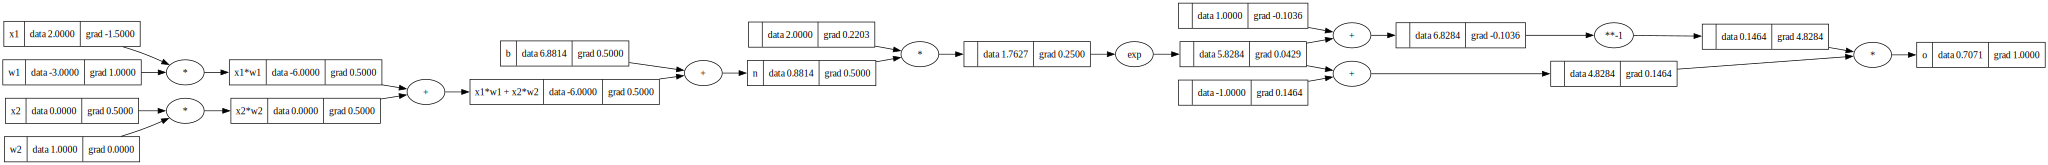

In [16]:
draw_dot(o)

In [17]:
# backward prop

# start from the top
# base case set o.grad() to 0
# o.grad = 1.0
o.backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [18]:
# making a topological graph to iterate through the graph for backprop (automate the proces. fist go through each node's children and valls the func. after going through the children it adds itself)

# topo = []
# visited = set()


# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)


# build_topo(o)

# for node in reversed(topo):
#     node._backward()

In [19]:
a = Value(2.0)
a + 1

Value(data=3.0)

In [28]:
# neuron class
import random


class Neuron:
    # neuron class within which we will define incoming inputs/weights as well as its bias

    def __init__(self, nin):
        """
        nin: Number of inputs. Equivalent to number of neurons in input layer
        """
        # initializing collection of weights -> number of inputs/inital neurons
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # calls the equation to calculate activation value: (w * x) + b
        # if you are unfamilar with zip() check this out: https://www.geeksforgeeks.org/zip-in-python/
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        # apply activation function for non-linearity + suppress value within a specified range
        out = act.tanh()
        return out


class Layer:
    # a layer contains multiple Neuron objects

    def __init__(self, nin, nout):
        """
        nin:  number of incoming neurons/weights for one Neuron in layer
        nout: number of outputs/how many neurons do you want in the layer
        """
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs


class MLP:
    # define number of layers and number of neurons in each layer

    def __init__(self, nin, nouts):
        """
        nin:   number of inputs
        nouts: list of layer sizes / number of neurons in each layer
        """
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

[Value(data=-0.8057319582423097)]

In [ ]:
# loss: measure that shows how well a neural network is performing 
# here we will implement MSE (mean squred error)
